In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count

fns = []
for dirname, _, filenames in os.walk('/content/data'):
    for filename in filenames:
        fns.append(os.path.join(dirname, filename))

df = pd.concat(objs=[
    pd.read_parquet(f) for f in fns
], copy=False, sort=False)

df = df.drop(columns=['Family'])

df['proto'] = df['proto'].astype('category').cat.codes
df['dir'] = df['dir'].astype('category').cat.codes
df['state'] = df['state'].astype('category').cat.codes

df = df.dropna()
df = df.drop_duplicates()

df['label'] = df['label'].astype(dtype='object')
df['label'] = df['label'].str.startswith('flow=From-Botnet', na=False)
df['label'] = df['label'].astype(dtype='float32', copy=False)

target = 'label'
conts = list(df.columns.difference([target]).values)

# Splitting the data into train and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

def xs_y(df_, targ):
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

# Selecting important features using model
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, n_jobs=-1))
sel.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score

selected_feat= X_train.columns[(sel.get_support())]

clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)

# Combine the models into an ensemble
ensemble = VotingClassifier(
    estimators=[('rf', clf1), ('gb', clf2), ('dt', clf3)],
    voting='soft')

# Perform 5-fold cross validation on the ensemble model
cv_scores = cross_val_score(clf1, X_train[selected_feat], y_train, cv=5)

# Print the mean cross-validation score
print('Mean cross-validation score:', np.mean(cv_scores))

# Train the ensemble with selected features
ensemble.fit(X_train[selected_feat], y_train)

# Get the probabilities of the positive class
probs = ensemble.predict_proba(X_test[selected_feat])[:, 1]

# Calculate the roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Get the threshold for the maximum f1 score
thresholds = np.arange(0., 1., 0.01)
f1_scores = [f1_score(y_test, probs >= t) for t in thresholds]
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]

# Make predictions with the best threshold
prediction = (probs >= best_threshold)

print('Accuracy:', accuracy_score(y_test, prediction))
print('Precision:', precision_score(y_test, prediction))
print('Recall:', recall_score(y_test, prediction))
print('F1:', f1_scores[max_f1_index])

<ipython-input-4-8649f7950a9f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(dtype='object')


Mean cross-validation score: 0.9928507606007159
Accuracy: 0.9921041162848329
Precision: 0.7949913644214163
Recall: 0.6472159730033745
F1: 0.7135327856146334


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count

fns = []
for dirname, _, filenames in os.walk('/content/data'):
    for filename in filenames:
        fns.append(os.path.join(dirname, filename))

df = pd.concat(objs=[
    pd.read_parquet(f) for f in fns
], copy=False, sort=False)

df = df.drop(columns=['Family'])

df['proto'] = df['proto'].astype('category').cat.codes
df['dir'] = df['dir'].astype('category').cat.codes
df['state'] = df['state'].astype('category').cat.codes

df = df.dropna()
df = df.drop_duplicates()

df['label'] = df['label'].astype(dtype='object')
df['label'] = df['label'].str.startswith('flow=From-Botnet', na=False)
df['label'] = df['label'].astype(dtype='float32', copy=False)

target = 'label'
conts = list(df.columns.difference([target]).values)

# Splitting the data into train and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

def xs_y(df_, targ):
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

# Selecting important features using model
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, n_jobs=-1))
sel.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score

selected_feat= X_train.columns[(sel.get_support())]

# clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)
# clf3 = DecisionTreeClassifier(max_depth=23, random_state=1, class_weight='balanced')

# Combine the models into an ensemble
# ensemble = VotingClassifier(
#     estimators=[('rf', clf1), ('gb', clf2), ('dt', clf3)],
#     voting='soft')

# Perform 5-fold cross validation on the ensemble model
cv_scores = cross_val_score(clf2, X_train[selected_feat], y_train, cv=5)

# Print the mean cross-validation score
print('Mean cross-validation score:', np.mean(cv_scores))

# Train the ensemble with selected features
clf2.fit(X_train[selected_feat], y_train)

# Get the probabilities of the positive class
probs = clf2.predict_proba(X_test[selected_feat])[:, 1]

# Calculate the roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Get the threshold for the maximum f1 score
thresholds = np.arange(0., 1., 0.01)
f1_scores = [f1_score(y_test, probs >= t) for t in thresholds]
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]

# Make predictions with the best threshold
prediction = (probs >= best_threshold)

print('Accuracy:', accuracy_score(y_test, prediction))
print('Precision:', precision_score(y_test, prediction))
print('Recall:', recall_score(y_test, prediction))
print('F1:', f1_scores[max_f1_index])

<ipython-input-17-30f4100c9c1a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(dtype='object')


Mean cross-validation score: 0.9878090140229547
Accuracy: 0.9860326602462763
Precision: 0.5483816587997303
Recall: 0.4573959505061867
F1: 0.4987733823980375


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred = clf3.predict(X_test)
# 혼동 행렬 생성
cm = confusion_matrix(y_test, pred)

# 클래스 레이블 설정
labels = ['Negative', 'Positive']

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
df.head()

,dur,proto,dir,state,stos,dtos,tot_pkts,tot_bytes,src_bytes,label
0,9.016532,12,0,205,0.0,0.0,7,508,208,0.0
1,2.903761,12,0,229,0.0,0.0,3,184,122,0.0
2,3.032142,12,0,229,0.0,0.0,3,184,122,0.0
3,2.932428,12,0,229,0.0,0.0,3,184,122,0.0
4,6.017523,12,0,229,0.0,0.0,3,184,122,0.0


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    460980
         1.0       0.79      0.69      0.74      7112

    accuracy                           0.99    468092
   macro avg       0.89      0.84      0.87    468092
weighted avg       0.99      0.99      0.99    468092

F1-Score: 0.7379035292347054
AUC: 0.8433172614210026
Accuracy: 0.9925591550378985


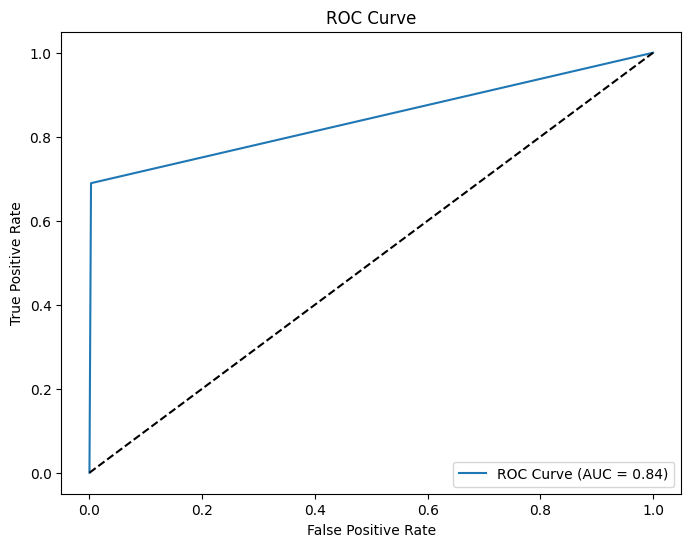

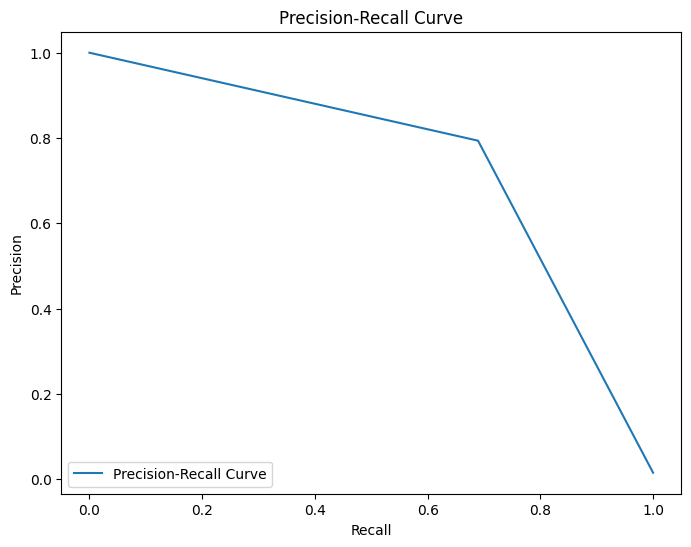

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# 성능 지표 계산
f1 = f1_score(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)

# 분류 보고서 출력
report = classification_report(y_test, prediction)
print(report)

# ROC Curve 계산
fpr, tpr, _ = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)

# Precision-Recall Curve 계산
precision, recall, _ = precision_recall_curve(y_test, prediction)

# 성능 지표 출력
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    460980
         1.0       0.67      0.66      0.67      7112

    accuracy                           0.99    468092
   macro avg       0.83      0.83      0.83    468092
weighted avg       0.99      0.99      0.99    468092

F1-Score: 0.6650585313941114
Accuracy: 0.9899143758064654


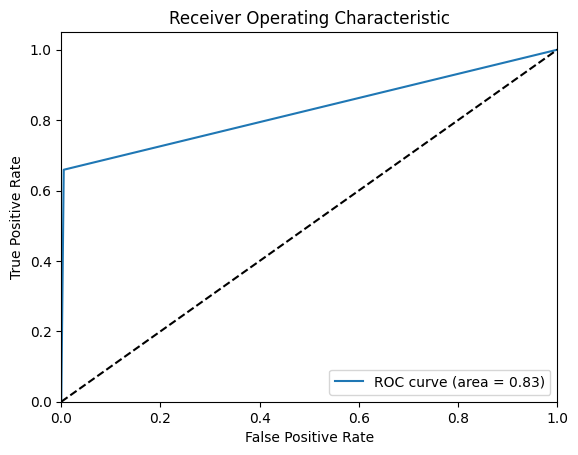

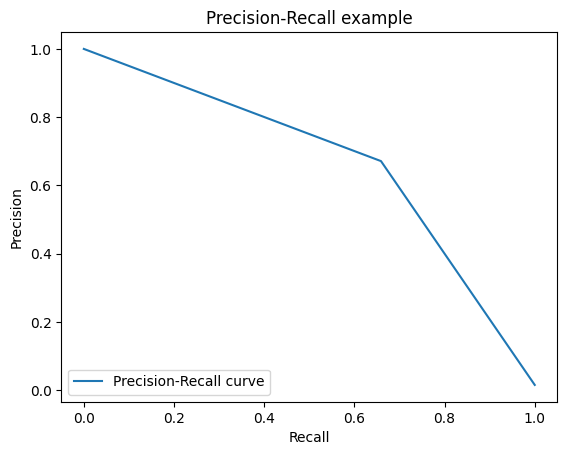

In [ ]:
# Convert the continuous outputs to binary outputs
from sklearn.metrics import classification_report,precision_recall_curve
preds = np.round(prediction)

# Compute performance metrics
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)
print(report)
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall and plot curve
precision, recall, _ = precision_recall_curve(y_test, preds)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall example')
plt.legend(loc="lower left")
plt.show()